importing packages

In [8]:
import pandas as pd
import numpy as np
import plotly.express as px

from datetime import timedelta
import geopy.distance as distance

reading provided dataset

In [9]:
metadata = pd.read_csv("metadata.csv")
metadata.head()

,uid,latitude,longitude,date,split
0,aabm,39.080319,-86.430867,14/05/2018,train
1,aabn,36.559700,-121.510000,31/08/2016,test
2,aacd,35.875083,-78.878434,19/11/2020,train
3,aaee,35.487000,-79.062133,24/08/2016,train
4,aaff,38.049471,-99.827001,23/07/2019,train


displaying data using plotly

In [10]:
fig = px.scatter_geo(metadata, lat='latitude',lon='longitude', hover_name="uid")
fig.update_layout(title = 'World map', title_x=0.5)
fig.show()

In [11]:
test_row = metadata[metadata.uid == "aabm"].iloc[0]
test_row

uid                aabm
latitude      39.080319
longitude    -86.430867
date         14/05/2018
split             train
Name: 0, dtype: object

In [12]:
# get our bounding box to search latitude and longitude coordinates
def get_bounding_box(latitude, longitude, meter_buffer=50000):
    """
    Given a latitude, longitude, and buffer in meters, returns a bounding
    box around the point with the buffer on the left, right, top, and bottom.

    Returns a list of [minx, miny, maxx, maxy]
    """
    distance_search = distance.distance(meters=meter_buffer)

    # calculate the lat/long bounds based on ground distance
    # bearings are cardinal directions to move (south, west, north, and east)
    min_lat = distance_search.destination((latitude, longitude), bearing=180)[0]
    min_long = distance_search.destination((latitude, longitude), bearing=270)[1]
    max_lat = distance_search.destination((latitude, longitude), bearing=0)[0]
    max_long = distance_search.destination((latitude, longitude), bearing=90)[1]

    return [min_long, min_lat, max_long, max_lat]


bbox = get_bounding_box(test_row.latitude, test_row.longitude, meter_buffer=50000)
bbox

[-87.00870397667829, 38.62992023013104, -85.85302936332171, 39.530683024019545]

In [13]:
# get our date range to search, and format correctly for query
def get_date_range(date, time_buffer_days=15):
    """Get a date range to search for in the planetary computer based
    on a sample's date. The time range will include the sample date
    and time_buffer_days days prior

    Returns a string"""
    datetime_format = "%Y-%m-%dT"

    range_start = pd.to_datetime(date) - timedelta(days=time_buffer_days)
    date_range = f"{range_start.strftime(datetime_format)}/{pd.to_datetime(date).strftime(datetime_format)}"

    return date_range


date_range = get_date_range(test_row.date)
date_range

/tmp/ipykernel_108568/1119165807.py:10: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.

/tmp/ipykernel_108568/1119165807.py:11: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.



'2018-04-29T/2018-05-14T'

idea: loop over entries and download images for the provided lat and long

In [14]:
import pystac_client
import planetary_computer as pc
import odc.stac
import matplotlib.pyplot as plt

from pystac.extensions.eo import EOExtension as eo

In [15]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=pc.sign_inplace,
)

In [16]:
# bbox_of_interest = [-122.2751, 47.5469, -121.9613, 47.7458]
bbox_of_interest = bbox
date_range = get_date_range(test_row.date)

/tmp/ipykernel_108568/1119165807.py:10: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.

/tmp/ipykernel_108568/1119165807.py:11: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.



In [17]:
# search the planetary computer sentinel-l2a and landsat level-2 collections
search = catalog.search(
    collections=["sentinel-2-l2a", "landsat-c2-l2"], bbox=bbox, datetime=date_range
)

# see how many items were returned
items = [item for item in search.get_all_items()]
len(items)

28

In [18]:
# get details of all of the items returned
item_details = pd.DataFrame(
    [
        {
            "datetime": item.datetime.strftime("%Y-%m-%d"),
            "platform": item.properties["platform"],
            "min_long": item.bbox[0],
            "max_long": item.bbox[2],
            "min_lat": item.bbox[1],
            "max_lat": item.bbox[3],
            "bbox": item.bbox,
            "item_obj": item,
        }
        for item in items
    ]
)

# check which rows actually contain the sample location
item_details["contains_sample_point"] = (
    (item_details.min_lat < test_row.latitude)
    & (item_details.max_lat > test_row.latitude)
    & (item_details.min_long < test_row.longitude)
    & (item_details.max_long > test_row.longitude)
)

print(
    f"Filtering from {len(item_details)} returned to {item_details.contains_sample_point.sum()} items that contain the sample location"
)

item_details = item_details[item_details["contains_sample_point"]]
item_details[["datetime", "platform", "contains_sample_point", "bbox"]].sort_values(
    by="datetime"
)

Filtering from 28 returned to 7 items that contain the sample location


,datetime,platform,contains_sample_point,bbox
26,2018-04-29,landsat-8,True,"[-87.5012704, 37.82811488, -84.80414448, 39.95..."
19,2018-05-03,Sentinel-2A,True,"[-87.000244, 38.754036048213806, -85.71872, 39..."
17,2018-05-06,landsat-8,True,"[-89.08857038, 37.81915492, -86.36282445, 39.9..."
13,2018-05-07,landsat-7,True,"[-87.58489065, 37.93487488, -84.73304468, 39.8..."
9,2018-05-08,Sentinel-2B,True,"[-87.00023345437725, 38.754036048213806, -85.7..."
2,2018-05-13,Sentinel-2A,True,"[-87.000244, 38.754036048213806, -85.71872, 39..."
0,2018-05-14,landsat-7,True,"[-89.16691061, 37.91775492, -86.28282464, 39.8..."


In [19]:
# 1 - filter to sentinel
item_details[item_details.platform.str.contains("Sentinel")]

,datetime,platform,min_long,max_long,min_lat,max_lat,bbox,item_obj,contains_sample_point
2,2018-05-13,Sentinel-2A,-87.000244,-85.71872,38.754036,39.750268,"[-87.000244, 38.754036048213806, -85.71872, 39...",<Item id=S2A_MSIL2A_20180513T162901_R083_T16SE...,True
9,2018-05-08,Sentinel-2B,-87.000233,-85.71872,38.754036,39.750268,"[-87.00023345437725, 38.754036048213806, -85.7...",<Item id=S2B_MSIL2A_20180508T162859_R083_T16SE...,True
19,2018-05-03,Sentinel-2A,-87.000244,-85.71872,38.754036,39.750268,"[-87.000244, 38.754036048213806, -85.71872, 39...",<Item id=S2A_MSIL2A_20180503T162901_R083_T16SE...,True


In [20]:
# 2 - take closest by date
best_item = (
    item_details[item_details.platform.str.contains("Sentinel")]
    .sort_values(by="datetime", ascending=False)
    .iloc[0]
)
best_item

datetime                                                        2018-05-13
platform                                                       Sentinel-2A
min_long                                                        -87.000244
max_long                                                         -85.71872
min_lat                                                          38.754036
max_lat                                                          39.750268
bbox                     [-87.000244, 38.754036048213806, -85.71872, 39...
item_obj                 <Item id=S2A_MSIL2A_20180513T162901_R083_T16SE...
contains_sample_point                                                 True
Name: 2, dtype: object

In [21]:
item = best_item.item_obj

In [22]:
# What assets are available?
for asset_key, asset in item.assets.items():
    print(f"{asset_key:<25} - {asset.title}")

AOT                       - Aerosol optical thickness (AOT)
B01                       - Band 1 - Coastal aerosol - 60m
B02                       - Band 2 - Blue - 10m
B03                       - Band 3 - Green - 10m
B04                       - Band 4 - Red - 10m
B05                       - Band 5 - Vegetation red edge 1 - 20m
B06                       - Band 6 - Vegetation red edge 2 - 20m
B07                       - Band 7 - Vegetation red edge 3 - 20m
B08                       - Band 8 - NIR - 10m
B09                       - Band 9 - Water vapor - 60m
B11                       - Band 11 - SWIR (1.6) - 20m
B12                       - Band 12 - SWIR (2.2) - 20m
B8A                       - Band 8A - Vegetation red edge 4 - 20m
SCL                       - Scene classfication map (SCL)
WVP                       - Water vapour (WVP)
visual                    - True color image
preview                   - Thumbnail
safe-manifest             - SAFE manifest
granule-metadata          - Granul

In [23]:
import rioxarray
from IPython.display import Image
from PIL import Image as PILImage

In [24]:
# see the whole image
img = Image(url=item.assets["rendered_preview"].href, width=500)

Image(url=item.assets["rendered_preview"].href, width=500)

In [25]:
def crop_sentinel_image(item, bounding_box):
    """
    Given a STAC item from Sentinel-2 and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box

    image = rioxarray.open_rasterio(pc.sign(item.assets["visual"].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    )

    return image.to_numpy()

In [26]:
# get a smaller geographic bounding box
minx, miny, maxx, maxy = get_bounding_box(
    test_row.latitude, test_row.longitude, meter_buffer=3000
)

# get the zoomed in image array
bbox = (minx, miny, maxx, maxy)
zoomed_img_array = crop_sentinel_image(item, bbox)

zoomed_img_array[0]

array([[104, 107, 104, ...,  57,  56,  57],
       [105, 114, 106, ...,  56,  56,  56],
       [116, 112, 101, ...,  56,  56,  55],
       ...,
       [ 76,  71,  57, ...,  60,  61,  62],
       [ 79,  82,  64, ...,  61,  58,  58],
       [ 77,  80,  66, ...,  60,  57,  55]], dtype=uint8)

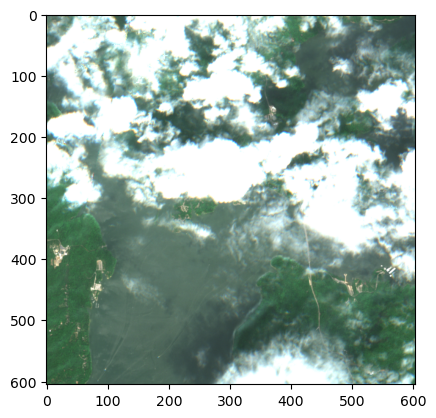

In [27]:
# we have to transpose some of the dimensions to plot
# matplotlib expects channels in a certain order
plt.imshow(np.transpose(zoomed_img_array, axes=[1, 2, 0]))